> Copyright 2022 University of Luxembourg
> 
> Licensed under the Apache License, Version 2.0 (the "License");  
> you may not use this file except in compliance with the License.  
> You may obtain a copy of the License at  
>
>    https://www.apache.org/licenses/LICENSE-2.0
>
> Unless required by applicable law or agreed to in writing, software  
> distributed under the License is distributed on an "AS IS" BASIS,  
> WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
> See the License for the specific language governing permissions and  
> limitations under the License.  
>
***

Author: André Stemper (andre.stemper@uni.lu)

***

In [27]:
if not 'experiment_timestamp_string' in locals():
    experiment_timestamp_string='20221021-095246'

if not 'measurements_root' in locals():
    measurements_root='./measurements' 

In [28]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime
import time
import pickle
import sys
import json
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


enable_example = False
%run dataset.ipynb


Measurement results directory

In [29]:
measurements_directory = measurements_root + os.path.sep + experiment_timestamp_string

**Load settings**

In [30]:
filename = measurements_directory + os.path.sep + 'settings.json'
with open(filename, 'r') as file:
    settings = json.load(file)
    print("Settings loaded from '{}'".format(filename))

print('Settings:')
for k, v in settings.items():
    print(" - {} = {}".format(k, v))

Settings loaded from './measurements/20221021-095246/settings.json'
Settings:
 - timestamp = 20221021-095246
 - dataset = 2022.04.06
 - range = experiment
 - frequency = 146
 - connection_type = remote
 - limit = None
 - threshold_hold_off = 60


**Features**  
Features to be packed into a datapoint and send to the implementaion. The order of the features must correspond to the ordering of a datapoint in the C++ implementation


In [31]:
feature_columns = ['temp_0', 'temp_1', 'temp_2', 'temp_3',
                   'temp_4', 'temp_5', 'temp_6', 'temp_7', 'temp_8']

In [32]:
dataset = Dataset(settings['dataset'])[settings['range']]


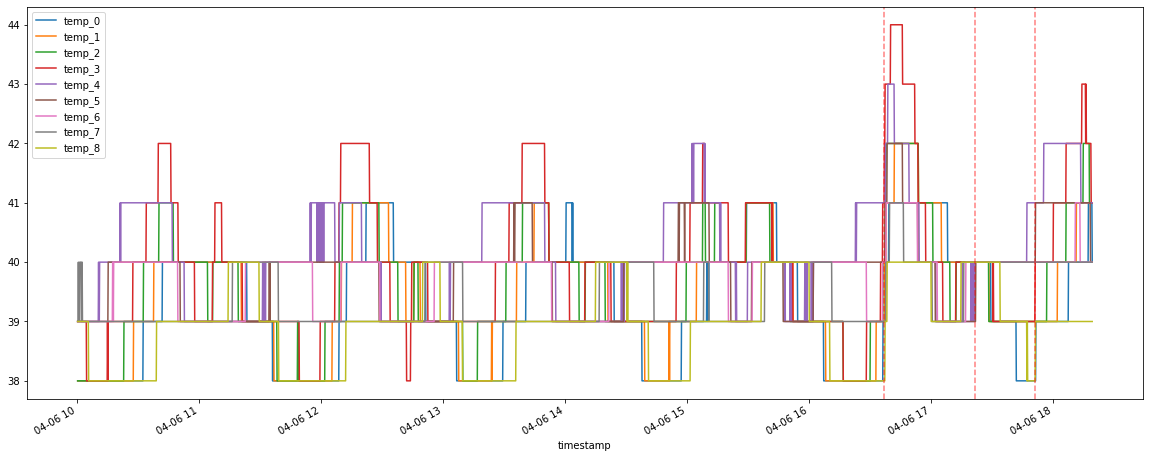

In [33]:
fig, ax = plt.subplots(1, 1, sharex=True)
fig.set_figwidth(20)
fig.set_figheight(8)
dataset.plot(columns=feature_columns, ax=ax).plot_anomalies(ax=ax)


**Load the specified dataset**


In [34]:


# load the dataframe extended with measurement data 
filename = measurements_directory + os.path.sep + "testbench_data.csv"
dataset.overwrite_dataframe_from_csv(filename=filename)


**Load statistics** 

In [35]:
filename = measurements_directory + os.path.sep + "execution_time_statistics.json"
with open(filename, 'r') as file:
    execution_time_statistics = json.load(file)  
    print("Statistics loaded from '{}'".format(filename))

print("Execution time / datapoint statistics")
for k, v in execution_time_statistics.items():
    print("{} \t= {} [s]".format(k, v))

Statistics loaded from './measurements/20221021-095246/execution_time_statistics.json'
Execution time / datapoint statistics
execution_time 	= {'mean': 0.006049189317106155, 'median': 1.0000000000000002e-06, 'std': 0.025621469424298403, 'min': 1.0000000000000002e-06, 'max': 0.33309700000000003, 'sum': 17.893502000000005, 'sample_size': 2958} [s]


### Postprocessing 
**Visualize the dataset and the results**


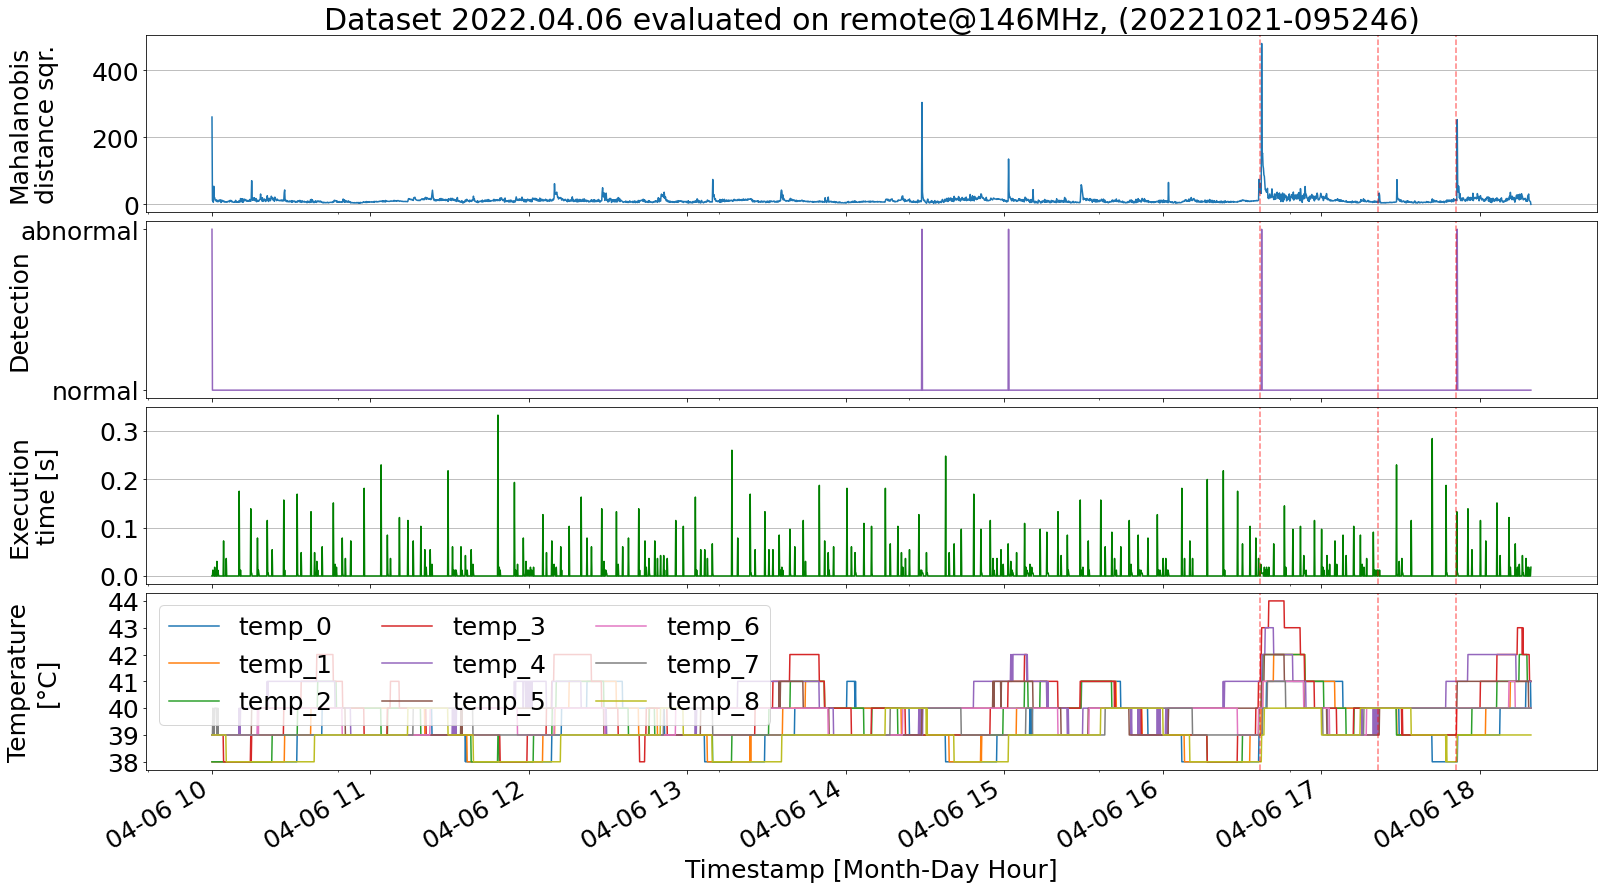

In [49]:

# setup font
fs = plt.rcParams.get('font.size')
plt.rcParams.update({'font.size': 25})

# ylabel_position = (-0.030, 0.5)
ylabel_position = (-0.06, 0.5)
fig, axs = plt.subplots(4, 1, sharex=True)
fig.set_figwidth(26)
fig.set_figheight(15)

axs[0].set_title("Dataset {} evaluated on {}@{}MHz, ({})".format(settings['dataset'], settings['connection_type'], settings['frequency'], experiment_timestamp_string),fontsize=30)
axs[3].yaxis.set_major_locator(MultipleLocator(1))
# axs[2].yaxis.set_minor_locator(MultipleLocator(0.5))
axs[3].set_ylabel("Temperature\n[°C]")
axs[3].yaxis.set_label_coords(*ylabel_position)
dataset.plot(columns=feature_columns, ax=axs[3]).plot_anomalies(ax=axs[3])

axs[0].set_ylabel("Mahalanobis\ndistance sqr.")
axs[0].yaxis.set_label_coords(*ylabel_position)
dataset.plot(columns=['distance'], ax=axs[0], grid=True).plot_anomalies(ax=axs[0])
axs[0].grid(axis='x')
axs[0].get_legend().remove()



axs[1].set_ylabel("Detection\n")
axs[1].yaxis.set_label_coords(*ylabel_position)
axs[1].set_yticks([1.0, 0.0], ["abnormal", "normal"])
dataset.plot(columns=['detection'], ax=axs[1], color='C4').plot_anomalies(ax=axs[1])
axs[1].get_legend().remove()

axs[2].yaxis.set_major_locator(MultipleLocator(0.5))
# axs[2].yaxis.set_minor_locator(MultipleLocator(0.5))
axs[2].set_ylabel("Execution\ntime [s]")
axs[2].yaxis.set_label_coords(*ylabel_position)
dataset.plot(columns=['execution_time'], ax=axs[2], grid=True, color='g').plot_anomalies(ax=axs[2])
axs[2].grid(axis='x')
axs[2].get_legend().remove()


axs[3].set_xlabel("Timestamp [Month-Day Hour]")

plt.legend(ncol=3)



fig.subplots_adjust(hspace=0.05)
filename = measurements_directory + os.path.sep + "postprocessing_testbench_results.png"
plt.savefig(filename)
filename = measurements_directory + os.path.sep + "postprocessing_testbench_results.pdf"
fs = plt.rcParams.get('font.size')
plt.rcParams.update({'font.size': 20})
plt.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0.1)
plt.rcParams.update({'font.size': fs})


timings_directory = measurements_root + os.path.sep + 'timings'
if not os.path.exists(timings_directory):
    os.mkdir(timings_directory)
plt.savefig(timings_directory + os.path.sep + "timing_{}.pdf".format(dataset.dataset_name), format='pdf', bbox_inches='tight', pad_inches=0.1)

# reset font
plt.rcParams.update({'font.size': fs})


**Histogram of excution duration**

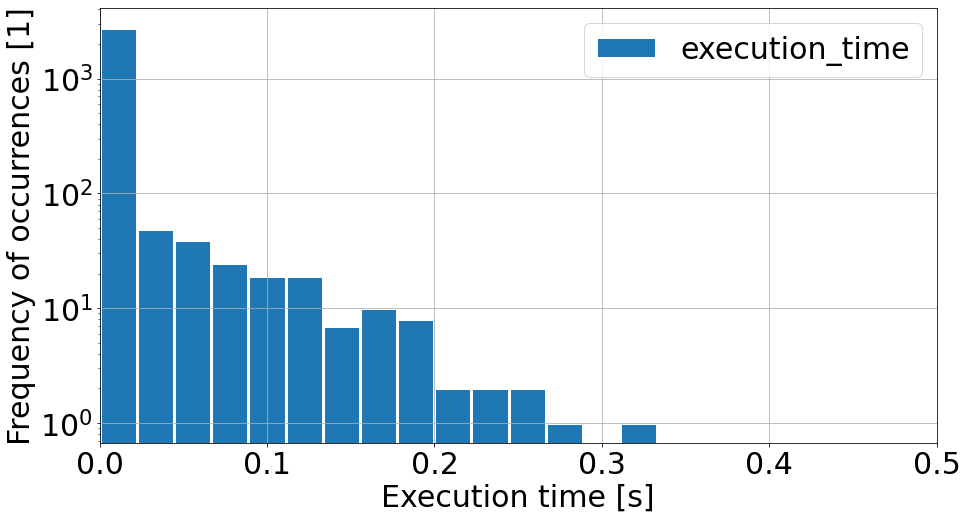

In [37]:
column = dataset.dataframe['execution_time']

# setup font
fs = plt.rcParams.get('font.size')
plt.rcParams.update({'font.size': 30})

if settings['connection_type'] == "local":
    ax=column.plot.hist(column=["execution_time"], bins=15, logy=True, xlim=[0,0.001], figsize=(15,8), edgecolor='white', linewidth=3, grid=True)
else:
    ax=column.plot.hist(column=["execution_time"], bins=15, logy=True, xlim=[0,0.5], figsize=(15,8), edgecolor='white', linewidth=3, grid=True)

ax.set_xlabel("Execution time [s]")
ax.set_ylabel("Frequency of occurrences [1]")

plt.legend(ncol=3)

filename = measurements_directory + os.path.sep + "postprocessing_testbench_histogram.png"
plt.savefig(filename)

filename = measurements_directory + os.path.sep + "postprocessing_testbench_histogram.pdf"
fs = plt.rcParams.get('font.size')
plt.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0.1)

histograms_directory = measurements_root + os.path.sep + 'histograms'
if not os.path.exists(histograms_directory):
    os.mkdir(histograms_directory)
plt.savefig(histograms_directory + os.path.sep + "histogram_{}.pdf".format(dataset.dataset_name), format='pdf', bbox_inches='tight', pad_inches=0.1)

# reset font
plt.rcParams.update({'font.size': fs})
